## What is Customer Lifetime Value(CLV)?

In marketing, **customer lifetime value(CLV or CLTV),lifetime customer value(LCV), or life-time value(LTV)** is a prognostication of the net profit contributed to the whole future relationship with a customer. The prediction model can have verying levels of sophistication and accuracy, ranging from a crude heuristic to the use of complex predictive analytics techniques.

Customer lifetime value can also be defined as the monetary value of a customer relationship, based on the present value of the projected future cash flows from the customer relationship. Customer lifetime value is an important concept in that it encourages firms to shift their focus from quarterly profits to the long-term health of their customer relationships. Customer lifetime value is an important metric because it represents an upper limit on spending to acquire new customers. For this reason it is an important element in calculating payback of advertising spent in marketing mix modeling.

## You can use CLV models to answer these types of questions about customers :

* **Number of purchases**: How many purchases will the customer make in a given future time range?
* **Lifetime**: How much time will pass before the customer becomes permanently inactive?
* **Monetary**: How much monetary value will the customer generate in a given future time range?

### CLV concepts: RFM (Customer Segmentation)
Three important inputs into CLV models are recency, frequency, and monetary value:

* **Recency**: When was the customer's last order?
* **Frequency**: How often do they buy?
* **Monetary**: What amount do they spend?
We will use RFM framework to build our customer segmentation model.

### Importing Libraries:

In [2]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Loading data
customer = pd.read_csv(r'C:\Users\ishita\Downloads\olist\olist_customers_dataset.csv')
order = pd.read_csv(r'C:\Users\ishita\Downloads\olist\olist_orders_dataset.csv')
item = pd.read_csv(r'C:\Users\ishita\Downloads\olist\olist_order_items_dataset.csv')
product = pd.read_csv(r'C:\Users\ishita\Downloads\olist\olist_products_dataset.csv')
product_category = pd.read_csv(r'C:\Users\ishita\Downloads\olist\product_category_name_translation.csv')
payment = pd.read_csv(r'C:\Users\ishita\Downloads\olist\olist_order_payments_dataset.csv')
review = pd.read_csv(r'C:\Users\ishita\Downloads\olist\olist_order_reviews_dataset.csv')

In [4]:
#getting order id by customer purchases 
df_customer_order=pd.merge(customer,order[['order_id','customer_id','order_purchase_timestamp']],on='customer_id')

In [5]:
df_customer_order.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'order_id',
       'order_purchase_timestamp'],
      dtype='object')

In [6]:
payment.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [7]:
#payments in same order id are combined to get total spending on an order
paid=payment[['order_id','payment_value']].groupby('order_id').sum().reset_index()
paid

,order_id,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,72.19
1,00018f77f2f0320c557190d7a144bdd3,259.83
2,000229ec398224ef6ca0657da4fc703e,216.87
3,00024acbcdf0a6daa1e931b038114c75,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,218.04
...,...,...
99435,fffc94f6ce00a00581880bf54a75a037,343.40
99436,fffcd46ef2263f404302a634eb57f7eb,386.53
99437,fffce4705a9662cd70adb13d4a31832d,116.85
99438,fffe18544ffabc95dfada21779c9644f,64.71


In [8]:
#now the total payment by each order is merged to the customer who has bought it to find the total amount purchase
df_customer_order_rev=pd.merge(df_customer_order,paid,on='order_id')

In [9]:
df_customer_order_rev.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'order_id',
       'order_purchase_timestamp', 'payment_value'],
      dtype='object')

In [10]:
#Now i will drop the unwanted columns
df_customer_order_rev.drop(['customer_zip_code_prefix','customer_city','customer_state'],axis=1,inplace=True)

In [11]:
df_customer_order_rev.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99440 entries, 0 to 99439
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               99440 non-null  object 
 1   customer_unique_id        99440 non-null  object 
 2   order_id                  99440 non-null  object 
 3   order_purchase_timestamp  99440 non-null  object 
 4   payment_value             99440 non-null  float64
dtypes: float64(1), object(4)
memory usage: 4.6+ MB


In [12]:
#convert order_purchase_timestamp to datetime column
df_customer_order_rev['order_purchase_timestamp']=pd.to_datetime(df_customer_order_rev['order_purchase_timestamp']).dt.date

In [13]:
df_customer_order_rev.isnull().sum()

customer_id                 0
customer_unique_id          0
order_id                    0
order_purchase_timestamp    0
payment_value               0
dtype: int64

### RFM Modelling:
Todo the RFM analysis, we need to create 3 freatures from the data:
* Recency: Latest date- last purchase date
* Frequency: Total no. of transactions made by a single customer (count of order id)
* Monetary: Total value of transacted sales by each customer.

### Recency

In [14]:
#find the last date on which customer made the purchase
recency=pd.DataFrame(df_customer_order_rev.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index())

In [15]:
recency['order_purchase_timestamp'].max()

datetime.date(2018, 10, 17)

In [16]:
#I take the maximum date of purchase made by customers as the date to calculate the recency of the purchase
#2018-10-17
recency['recent_days']=(recency['order_purchase_timestamp'].max()-recency['order_purchase_timestamp']).dt.days
recency

,customer_unique_id,order_purchase_timestamp,recent_days
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10,160
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07,163
2,0000f46a3911fa3c0805444483337064,2017-03-10,586
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12,370
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14,337
...,...,...,...
96090,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08,496
96091,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10,311
96092,ffff371b4d645b6ecea244b27531430a,2017-02-07,617
96093,ffff5962728ec6157033ef9805bacc48,2018-05-02,168


### Frequency

**We will count the number of unique orders made by each customer to obtain their purchase frequencies.**

In [17]:
#the number of times a unique customer has made purchase
frequency=pd.DataFrame(df_customer_order_rev.groupby('customer_unique_id')['customer_id'].count().reset_index())
frequency

,customer_unique_id,customer_id
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
96090,fffcf5a5ff07b0908bd4e2dbc735a684,1
96091,fffea47cd6d3cc0a88bd621562a9d061,1
96092,ffff371b4d645b6ecea244b27531430a,1
96093,ffff5962728ec6157033ef9805bacc48,1


### Monetary

In [18]:
monetary=pd.DataFrame(df_customer_order_rev[['customer_unique_id','payment_value']].groupby('customer_unique_id')['payment_value'].sum().reset_index())
monetary

,customer_unique_id,payment_value
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f46a3911fa3c0805444483337064,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,43.62
4,0004aac84e0df4da2b147fca70cf8255,196.89
...,...,...
96090,fffcf5a5ff07b0908bd4e2dbc735a684,2067.42
96091,fffea47cd6d3cc0a88bd621562a9d061,84.58
96092,ffff371b4d645b6ecea244b27531430a,112.46
96093,ffff5962728ec6157033ef9805bacc48,133.69


In [19]:
#now I will merge recency,frequency and monetary dataframe
df_rfm=pd.merge(recency,frequency,on='customer_unique_id')
df_rfm=pd.merge(df_rfm,monetary,on='customer_unique_id')
df_rfm

,customer_unique_id,order_purchase_timestamp,recent_days,customer_id,payment_value
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10,160,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07,163,1,27.19
2,0000f46a3911fa3c0805444483337064,2017-03-10,586,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12,370,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14,337,1,196.89
...,...,...,...,...,...
96090,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08,496,1,2067.42
96091,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10,311,1,84.58
96092,ffff371b4d645b6ecea244b27531430a,2017-02-07,617,1,112.46
96093,ffff5962728ec6157033ef9805bacc48,2018-05-02,168,1,133.69


In [20]:
#dropping unneccesary column
df_rfm.drop(['order_purchase_timestamp'],axis=1,inplace=True)
df_rfm

,customer_unique_id,recent_days,customer_id,payment_value
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,27.19
2,0000f46a3911fa3c0805444483337064,586,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,370,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,337,1,196.89
...,...,...,...,...
96090,fffcf5a5ff07b0908bd4e2dbc735a684,496,1,2067.42
96091,fffea47cd6d3cc0a88bd621562a9d061,311,1,84.58
96092,ffff371b4d645b6ecea244b27531430a,617,1,112.46
96093,ffff5962728ec6157033ef9805bacc48,168,1,133.69


In [21]:
# Recency= Days from last purchase
#Frequency= Number of purchase made
#Monetary= total amount purchased by a customer
df_rfm.columns=['Customer_unique_id','Recency','Frequency','Monetary']
df_rfm.reset_index()
df_rfm.set_index("Customer_unique_id",inplace=True)

In [22]:
df_rfm

,Recency,Frequency,Monetary
Customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,160,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,27.19
0000f46a3911fa3c0805444483337064,586,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,370,1,43.62
0004aac84e0df4da2b147fca70cf8255,337,1,196.89
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,496,1,2067.42
fffea47cd6d3cc0a88bd621562a9d061,311,1,84.58
ffff371b4d645b6ecea244b27531430a,617,1,112.46


In [23]:
#descriptive stats for the RFM analysis
df_rfm.describe()

,Recency,Frequency,Monetary
count,96095.000000,96095.000000,96095.000000
mean,288.103866,1.034809,166.594226
std,153.411050,0.214385,231.428912
min,0.000000,1.000000,0.000000
25%,164.000000,1.000000,63.120000
50%,269.000000,1.000000,108.000000
75%,397.000000,1.000000,183.530000
max,773.000000,17.000000,13664.080000


In [24]:
(df_rfm[df_rfm["Frequency"]>1].shape[0]/96095)*100

3.1187886986835944

 From this above calculation we can say that around **97% customers** are one time customers and only **3% are recurring customers**.

<AxesSubplot:xlabel='Monetary', ylabel='Density'>

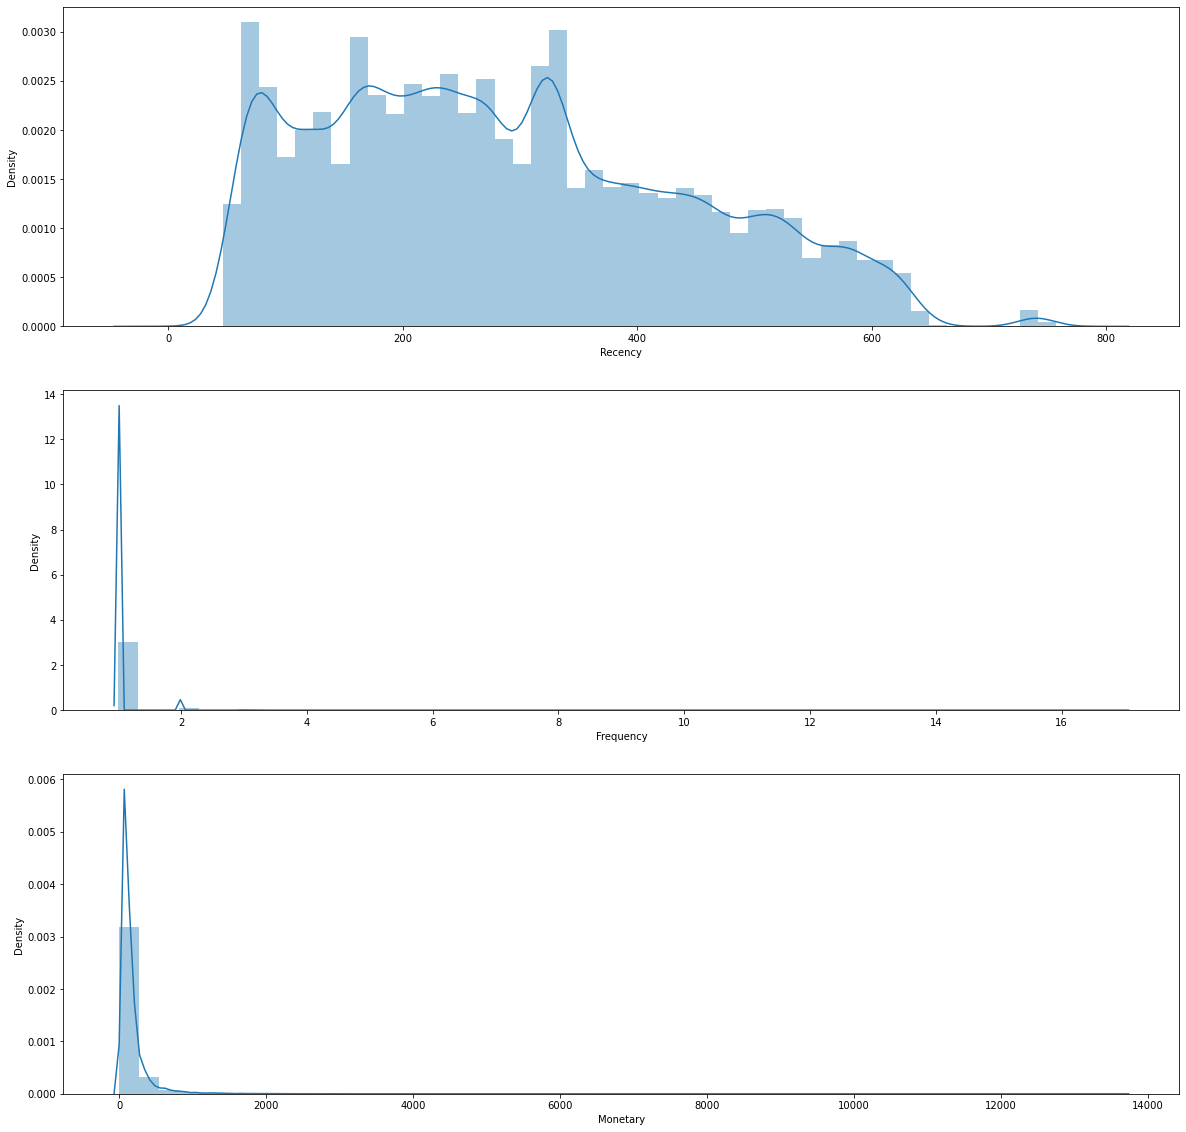

In [25]:
#plot RFM distribution
plt.figure(figsize=(20,20))
#plot distribution of Recency
plt.subplot(3,1,1);
sns.distplot(df_rfm["Recency"])

#plot distribution of Frequency
plt.subplot(3,1,2);
sns.distplot(df_rfm["Frequency"])

#plot distribution of Monetary
plt.subplot(3,1,3);
sns.distplot(df_rfm["Monetary"])

## RFM Quartiles

The simples way to create customers segments from RFM model is to use quartiles.We assign score from **1 to 4** to Recency,Frequency and Monetary.**4** is the best/heighest value, and **1** is the lowest/worst value. A RFM scoreis calculated simply by combining individual RFM score numbers.

In [26]:
quantiles=df_rfm.quantile(q=[0.25,0.5,0.75])
quantiles.to_dict()

{'Recency': {0.25: 164.0, 0.5: 269.0, 0.75: 397.0},
 'Frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 1.0},
 'Monetary': {0.25: 63.12, 0.5: 108.0, 0.75: 183.53}}

We will create two segmentation classes since high recency is bad, while high frequency and monetary value is good.

In [27]:
#x=value, p=recency,frequency, monetary_value,  d=quartiles dict
def RScore(x,p,d):
    if x<=d[p][0.25]:
        return 4
    elif x<= d[p][0.50]:
        return 3
    elif x<= d[p][0.75]:
        return 2
    else:
        return 1

# x=value, p=recency,frequency, monetary_value,  k=quartiles dict
def FMScore(x,p,k):
    if x<=k[p][0.25]:
        return 1
    elif x<=k[p][0.50]:
        return 2
    elif x<=k[p][0.75]:
        return 3
    else:
        return 4

In [28]:
#create RFM segmentation table
rfm_segmentation=df_rfm
rfm_segmentation['R_Quartile']=rfm_segmentation["Recency"].apply(RScore,args=('Recency',quantiles))
rfm_segmentation['F_Quartile']=rfm_segmentation["Frequency"].apply(FMScore,args=('Frequency',quantiles))
rfm_segmentation['M_Quartile']=rfm_segmentation["Monetary"].apply(FMScore,args=('Monetary',quantiles))

In [33]:
rfm_segmentation

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile
Customer_unique_id,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,160,1,141.90,4,1,3
0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,27.19,4,1,1
0000f46a3911fa3c0805444483337064,586,1,86.22,1,1,2
0000f6ccb0745a6a4b88665a16c9f078,370,1,43.62,2,1,1
0004aac84e0df4da2b147fca70cf8255,337,1,196.89,2,1,4
...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,496,1,2067.42,1,1,4
fffea47cd6d3cc0a88bd621562a9d061,311,1,84.58,2,1,2
ffff371b4d645b6ecea244b27531430a,617,1,112.46,1,1,3


In [34]:
rfm_segmentation['RFMScore']=rfm_segmentation.R_Quartile.map(str)+rfm_segmentation.F_Quartile.map(str)+rfm_segmentation.M_Quartile.map(str)
rfm_segmentation

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore
Customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,160,1,141.90,4,1,3,413
0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,27.19,4,1,1,411
0000f46a3911fa3c0805444483337064,586,1,86.22,1,1,2,112
0000f6ccb0745a6a4b88665a16c9f078,370,1,43.62,2,1,1,211
0004aac84e0df4da2b147fca70cf8255,337,1,196.89,2,1,4,214
...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,496,1,2067.42,1,1,4,114
fffea47cd6d3cc0a88bd621562a9d061,311,1,84.58,2,1,2,212
ffff371b4d645b6ecea244b27531430a,617,1,112.46,1,1,3,113


In [64]:
def segment(x):
    if x in ['444','443','433','442','434']:
        return 'Best_customer'
    elif x in [ '432','341','342','332','333','344','343','441']:
        return 'Loyal_customer'
    elif x in ['334', '234','214','224','413','314','244','243']:
        return 'Big_spender'
    elif x in ['212', '213', '222','211','114','311','312','214','143','142','141','241']:
        return 'Almost_lost'
    elif x in ['111', '121','112','113','144']:
        return 'Lost_customer'
    else:
        return 'New_customer'
    
   

In [65]:
rfm_segmentation['segments'] = rfm_segmentation['RFMScore'].apply(segment)
rfm_segmentation['segments'].value_counts()

Almost_lost       35269
New_customer      23308
Lost_customer     18220
Big_spender       17642
Best_customer       846
Loyal_customer      810
Name: segments, dtype: int64

In [67]:
segmentwise = rfm_segmentation.groupby('segments').agg(RecencyMean = ('Recency', 'mean'),
                                          FrequencyMean = ('Frequency', 'mean'),
                                          MonetaryMean = ('Monetary', 'mean'),
                                          GroupSize = ('Recency', 'size'))
segmentwise

,RecencyMean,FrequencyMean,MonetaryMean,GroupSize
segments,,,,
Almost_lost,319.931243,1.008137,130.599485,35269
Best_customer,105.600473,2.161939,343.968794,846
Big_spender,217.844519,1.039225,300.261133,17642
Lost_customer,501.934742,1.021460,94.112704,18220
Loyal_customer,216.335802,2.128395,296.695679,810
New_customer,135.088897,1.003346,165.586812,23308


In [52]:
!pip install squarify

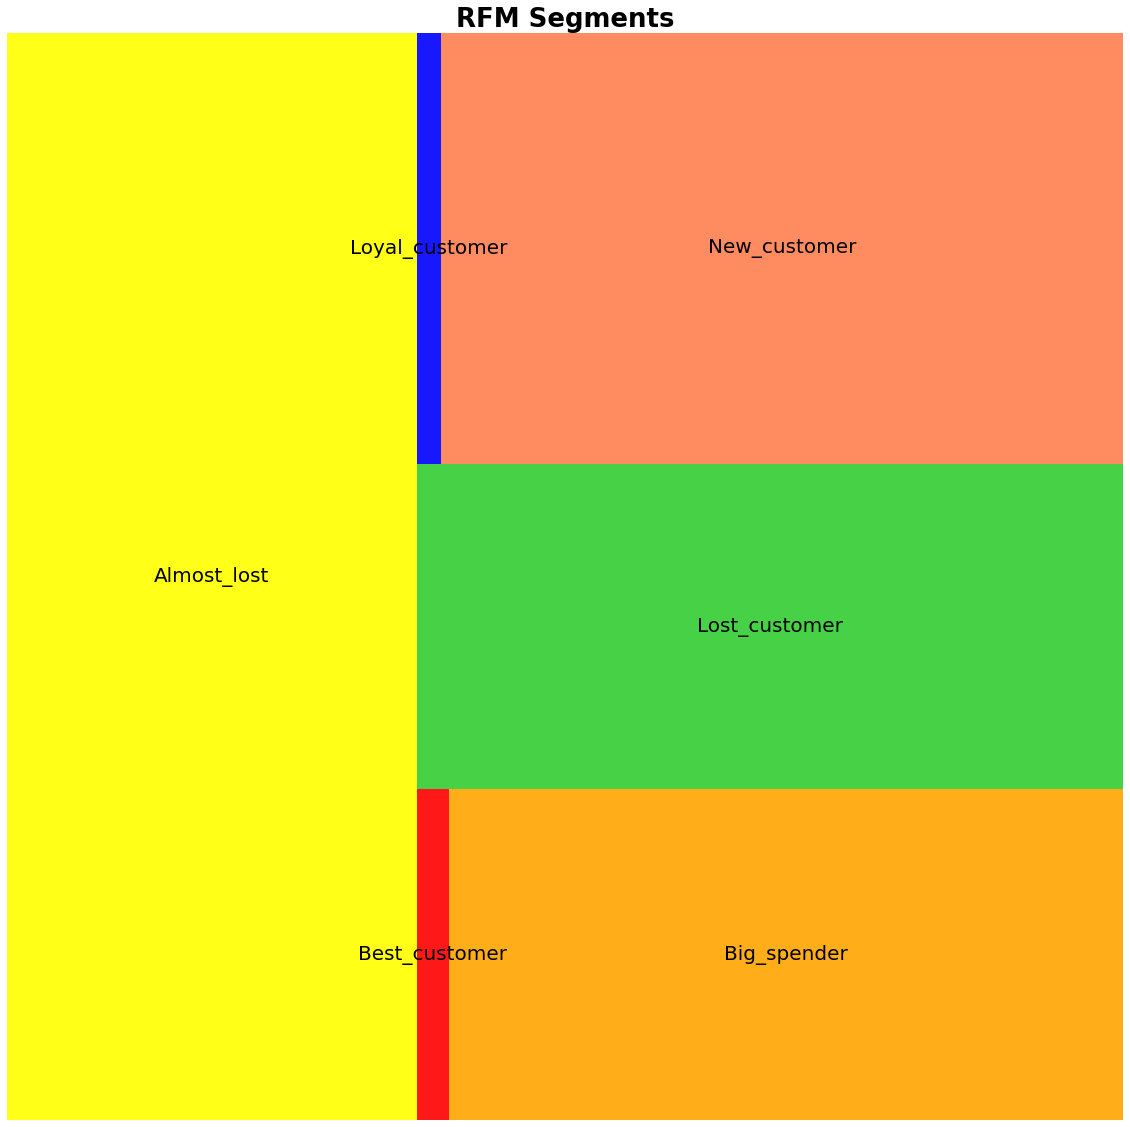

In [81]:
import squarify

fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(20, 20)
squarify.plot(sizes = segmentwise['GroupSize'], 
              label = segmentwise.index,
              color = ['yellow', 'red', 'orange', 'limegreen', 'blue', 'coral'],
              alpha = 0.9,text_kwargs={'fontsize':20})
plt.title("RFM Segments",fontsize=26,fontweight="bold")
plt.axis('off')
plt.show()